In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path
from sklearn.cluster import KMeans

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS, FREQUENCY_COLOR_MAPPINGS
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt

from cli import get_file_paths
from calls import plot_call_features, compute_features, call_extraction

['/Users/adityakrishna/duty-cycle-investigation/daily_notebook', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python311.zip', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/lib-dynload', '', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages', '../src', '../src/bout', '../src/bout', '../src/bout', '../src/bout', '../src', '../src', '../src/activity', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/calls', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/bout', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src']


In [4]:
label_for_groups = {0: 'LF', 1: 'HF'}

Looking at Central Pond


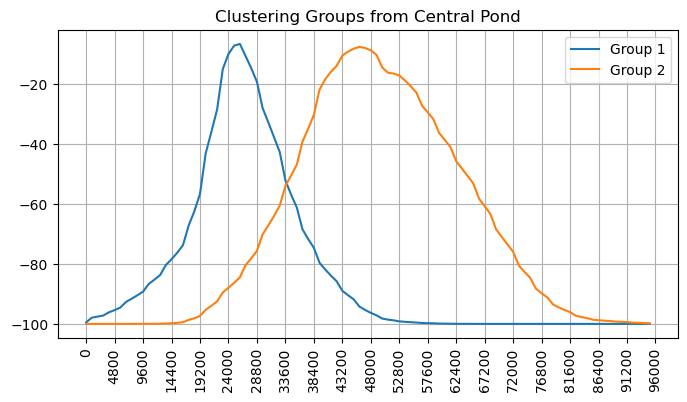

In [5]:
site_key = 'Central'

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
print(f'Looking at {fig_details["site_name"]}')

output_dir = Path(f'../data/generated_welch/{site_key}')
if not(output_dir.is_dir()):
    output_dir.mkdir(parents=True)
output_file_type = 'top1_inbouts_welch_signals'

welch_data = pd.read_csv(output_dir / f'2022_{site_key}_{output_file_type}.csv', index_col=0, low_memory=False)

k = 2
kmean_welch = KMeans(n_clusters=k, n_init=10, random_state=1).fit(welch_data.values)
plt.figure(figsize=(8, 4))
plt.title(f'Clustering Groups from {SITE_NAMES[site_key]}')
for i in range(k):
    plt.plot(kmean_welch.cluster_centers_[i], label=f'Group {i+1}')
plt.xticks(np.linspace(0, welch_data.shape[1], 21), np.linspace(0, 96000, 21, dtype=int), rotation=90)
plt.grid(which='both')
plt.legend()
plt.show()

In [6]:
filepath_key = EXAMPLE_FILES_from_LOCATIONS[site_key][5]
filename = filepath_key.split('/')[-1]

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 280
duration = 30
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 4096
spec_features['cmap'] = 'jet'

In [7]:
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

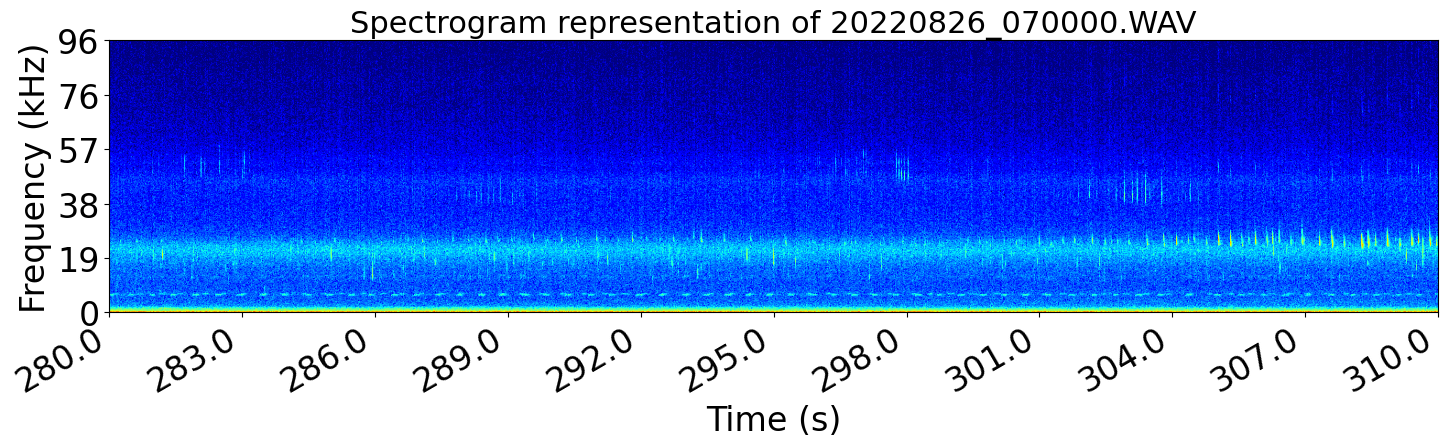

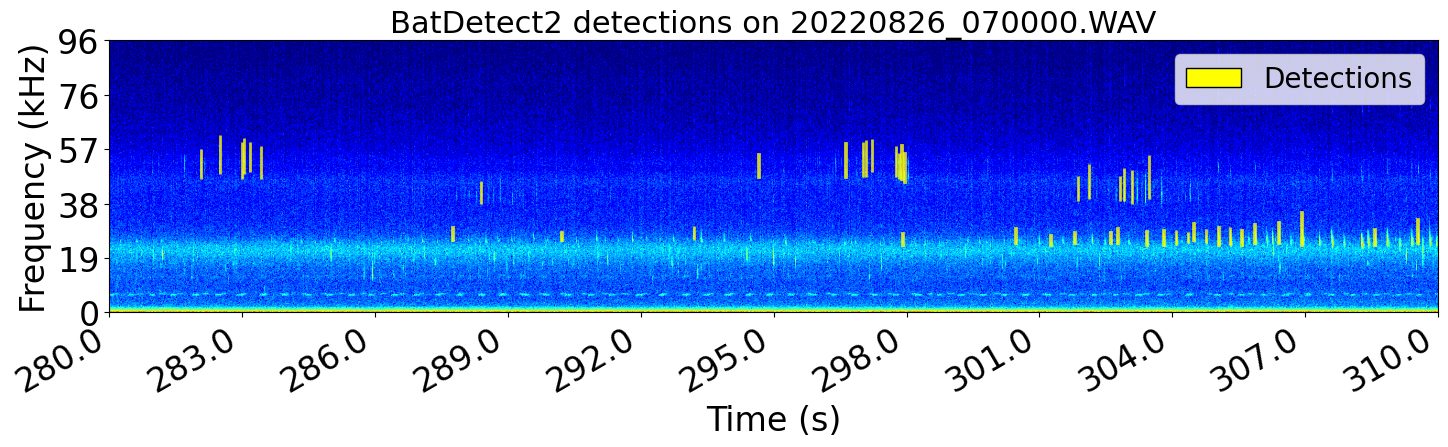

In [8]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)

In [9]:
dets = plot_dets_no_dutycycle.copy()
dets.head(1)

,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Recover Folder,SD Card,Site name
232,HF2,2022-08-26 07:04:42.076500,2022-08-26 07:04:42.076500,2022-08-26 07:04:42.081300,282.0765,282.0813,46953.0,57628.0,Pipistrellus pipistrellus,0.538,0.564,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond


In [10]:
test = np.arange(1, 10)
test

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
ts = 4
te = 6
print(test[ts:te])
print(test[ts:ts - (te-ts):-1][::-1])

[5 6]
[4 5]


In [12]:
call_signals = []
welch_signals = []
snrs = []
peak_freqs = []
classes = []
nyquist = fs//2
for index, row in dets.iterrows():
    call_dur = (row['end_time'] - row['start_time'])
    pad = 0.004
    start = row['start_time'] - call_dur - (3*pad)
    duration = (2 * call_dur) + (4*pad)
    end = row['end_time']
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    
    low_freq_cutoff = row['low_freq']-5000
    high_freq_cutoff = min(nyquist-1, row['high_freq']+5000)
    band_limited_audio_seg = call_extraction.bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

    signal = band_limited_audio_seg.copy()
    signal[:int(fs*(call_dur+(2*pad)))] = 0

    noise = band_limited_audio_seg - signal

    snr_call_signal = signal[-int(fs*(call_dur+(2*pad))):]
    snr_noise_signal = noise[:int(fs*(call_dur+(2*pad)))]
    call_signals.append(snr_call_signal)

    snr = call_extraction.get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal)
    snrs.append(snr)

    welch_info = dict()
    welch_info['num_points'] = 100
    max_visible_frequency = 96000
    welch_info['max_freq_visible'] = max_visible_frequency
    welch_signal = compute_features.compute_welch_psd_of_call(snr_call_signal, fs, welch_info)
    welch_signals.append(welch_signal)
    welch_signal = (welch_signal).reshape(1, len(welch_signal))

    peaks = np.where(welch_signal==max(welch_signal))[0][0]
    peak_freqs.append((96000/100)*peaks)
    classes.append(kmean_welch.predict(welch_signal)[0])

call_signals = np.array(call_signals, dtype='object')

In [13]:
dets.reset_index(drop=True, inplace=True)
dets['index'] = dets.index
dets['file_name'] = pd.DatetimeIndex(pd.to_datetime(dets['input_file'], format='%Y%m%d_%H%M%S', exact=False)).strftime('%Y%m%d_%H%M%S.WAV')
dets['sampling_rate'] = len(dets) * [fs]
dets['SNR'] = snrs
dets['KMEANS_CLASSES'] = pd.Series(classes).map(label_for_groups)

In [14]:
PADDED_CALL_LENGTH = 0.06

def plot_n_specs_long_layout(call_indices, calls_sampled, call_signals, site_key):
    side = np.ceil(np.sqrt(len(call_indices))).astype('int')
    plt.figure(figsize=(2.5*len(call_indices), 4))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(f'Visualizing KMeans on {calls_sampled["file_name"].values[0]} from {SITE_NAMES[site_key]}', y=1, fontsize=50)
    for subplot_i, call_index in enumerate(call_indices):
        call_info = calls_sampled.loc[call_index]
        file_name = call_info['file_name']
        datetime = dt.datetime.strptime(file_name, "%Y%m%d_%H%M%S.WAV")

        plt.subplot(1, len(call_indices), subplot_i+1)
        audio_info = dict()
        audio_info['call_index'] = call_index
        audio_info['plot_title'] = f'Call Classified as {call_info["KMEANS_CLASSES"]}'
        audio_info['show_yaxis_fine'] = False
        plot_call_spectrogram_centered(calls_sampled, call_signals, audio_info)

    plt.tight_layout()
    plt.show()

def plot_n_specs_square_layout(call_indices, calls_sampled, call_signals, site_key):
    side = np.ceil(np.sqrt(len(call_indices))).astype('int')
    plt.figure(figsize=(2.5*side, 2.5*side))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(f'Visualizing KMeans on {calls_sampled["file_name"].values[0]} from {SITE_NAMES[site_key]}', y=1, fontsize=50)
    for subplot_i, call_index in enumerate(call_indices):
        call_info = calls_sampled.loc[call_index]
        file_name = call_info['file_name']
        datetime = dt.datetime.strptime(file_name, "%Y%m%d_%H%M%S.WAV")

        plt.subplot(side, side, subplot_i+1)
        audio_info = dict()
        audio_info['call_index'] = call_index
        audio_info['plot_title'] = f'Call Index: {call_index}'
        audio_info['show_yaxis_fine'] = False
        plot_call_spectrogram_centered(calls_sampled, call_signals, audio_info)

    plt.tight_layout()
    plt.show()

def plot_call_spectrogram_centered(calls_sampled, call_signals, audio_info):
    call_info = calls_sampled.loc[audio_info['call_index']]
    fs = call_info['sampling_rate']
    call = call_signals[call_info['index']]
    padded_call = compute_features.pad_call_ms(call, fs, PADDED_CALL_LENGTH)

    padded_call_dur = round(len(padded_call)/fs, 2)
    plt.title(audio_info['plot_title'], fontsize=12, weight='bold')
    plt.specgram(padded_call, NFFT=132, cmap='jet', vmin=-60)
    time_labels = (np.linspace(0,1000*padded_call_dur, 11).astype('int')).astype('str')
    time_labels[1::2] = ''
    plt.xticks(ticks=np.linspace(0,round(len(padded_call)/2), 11), labels=time_labels, rotation=45)
    ax = plt.gca()
    plt.text(x=0.4, y=0.05, s=f'SNR:{round(call_info["SNR"], 1)}', color='white', fontweight='bold', transform=ax.transAxes)
    plt.text(x=0.1, y=0.75, s=f'{call_info["KMEANS_CLASSES"]}', color='white', fontsize=24, fontweight='bold', transform=ax.transAxes)

    low_end = 0
    high_end = 96000
    freq_labels = (np.linspace(low_end/1000, high_end/1000, 11)).astype('int').astype('str')
    if not(audio_info['show_yaxis_fine']):
        freq_labels[1::2] = ''
    plt.yticks(ticks=np.linspace(2*low_end/(fs), 2*high_end/(fs), 11), labels=freq_labels, rotation=45)
    plt.ylim(2*low_end/(fs), 2*high_end/(fs))
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (kHz)')
    plt.grid(which='both')

def plot_n_welch_square_layout(call_indices, calls_sampled, call_signals, site_key):
    side = np.ceil(np.sqrt(len(call_indices))).astype('int')
    num_points = 100
    plt.figure(figsize=(2.8*side, 2.8*side))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(f'{SITE_NAMES[site_key]} {side**2} Welch spectrum signals ({num_points} points per signal)', y=1, fontsize=50)
    for subplot_i, call_index in enumerate(call_indices):
        call_info = calls_sampled.loc[call_index]
        file_name = call_info['file_name']
        datetime = dt.datetime.strptime(file_name, "%Y%m%d_%H%M%S.WAV")


        plt.subplot(side, side, subplot_i+1)
        audio_info = dict()
        audio_info['call_index'] = call_index
        audio_info['plot_title'] = f'{(datetime).strftime("%m/%d/%y %H:%M")}'
        audio_info['num_points'] = num_points
        audio_info['show_yaxis_fine'] = False
        plot_call_welch_interpolated(calls_sampled, call_signals, audio_info)
        
    plt.tight_layout()
    plt.show()

def plot_call_welch_interpolated(calls_sampled, call_signals, audio_info):
    call_info = calls_sampled.loc[audio_info['call_index']]
    fs = call_info['sampling_rate']
    call = call_signals[call_info['index']]
    max_visible_frequency = 96000
    audio_info['max_freq_visible'] = max_visible_frequency

    interpolated_points_from_welch = compute_features.compute_welch_psd_of_call(call, fs, audio_info)
    peaks = np.where(interpolated_points_from_welch==max(interpolated_points_from_welch))[0][0]

    welch_signal = interpolated_points_from_welch
    plt.title(audio_info['plot_title'], fontsize=12, weight='bold')
    plot_freqs = np.linspace(0, max_visible_frequency, len(welch_signal))
    plt.plot(plot_freqs, welch_signal, label=f'SNR:{round(call_info["SNR"], 1)}', color='blue')
    plt.scatter(peaks*(96000/100), interpolated_points_from_welch[peaks], marker='.', color='red', s=200)
    freq_labels = np.linspace(0, max_visible_frequency/(1000), 9, dtype='int').astype('str')
    if not(audio_info['show_yaxis_fine']):
        freq_labels[1::2] = ''
    plt.xticks(ticks=np.linspace(0, max_visible_frequency, 9), labels=freq_labels, rotation=45)
    plt.ylabel("FFT Magnitude (dB)")
    plt.xlabel("Frequency (kHz)")
    plt.xlim(0, max_visible_frequency)
    plt.ylim(-110, 10)
    plt.grid(which='both')
    plt.legend(loc='lower center')

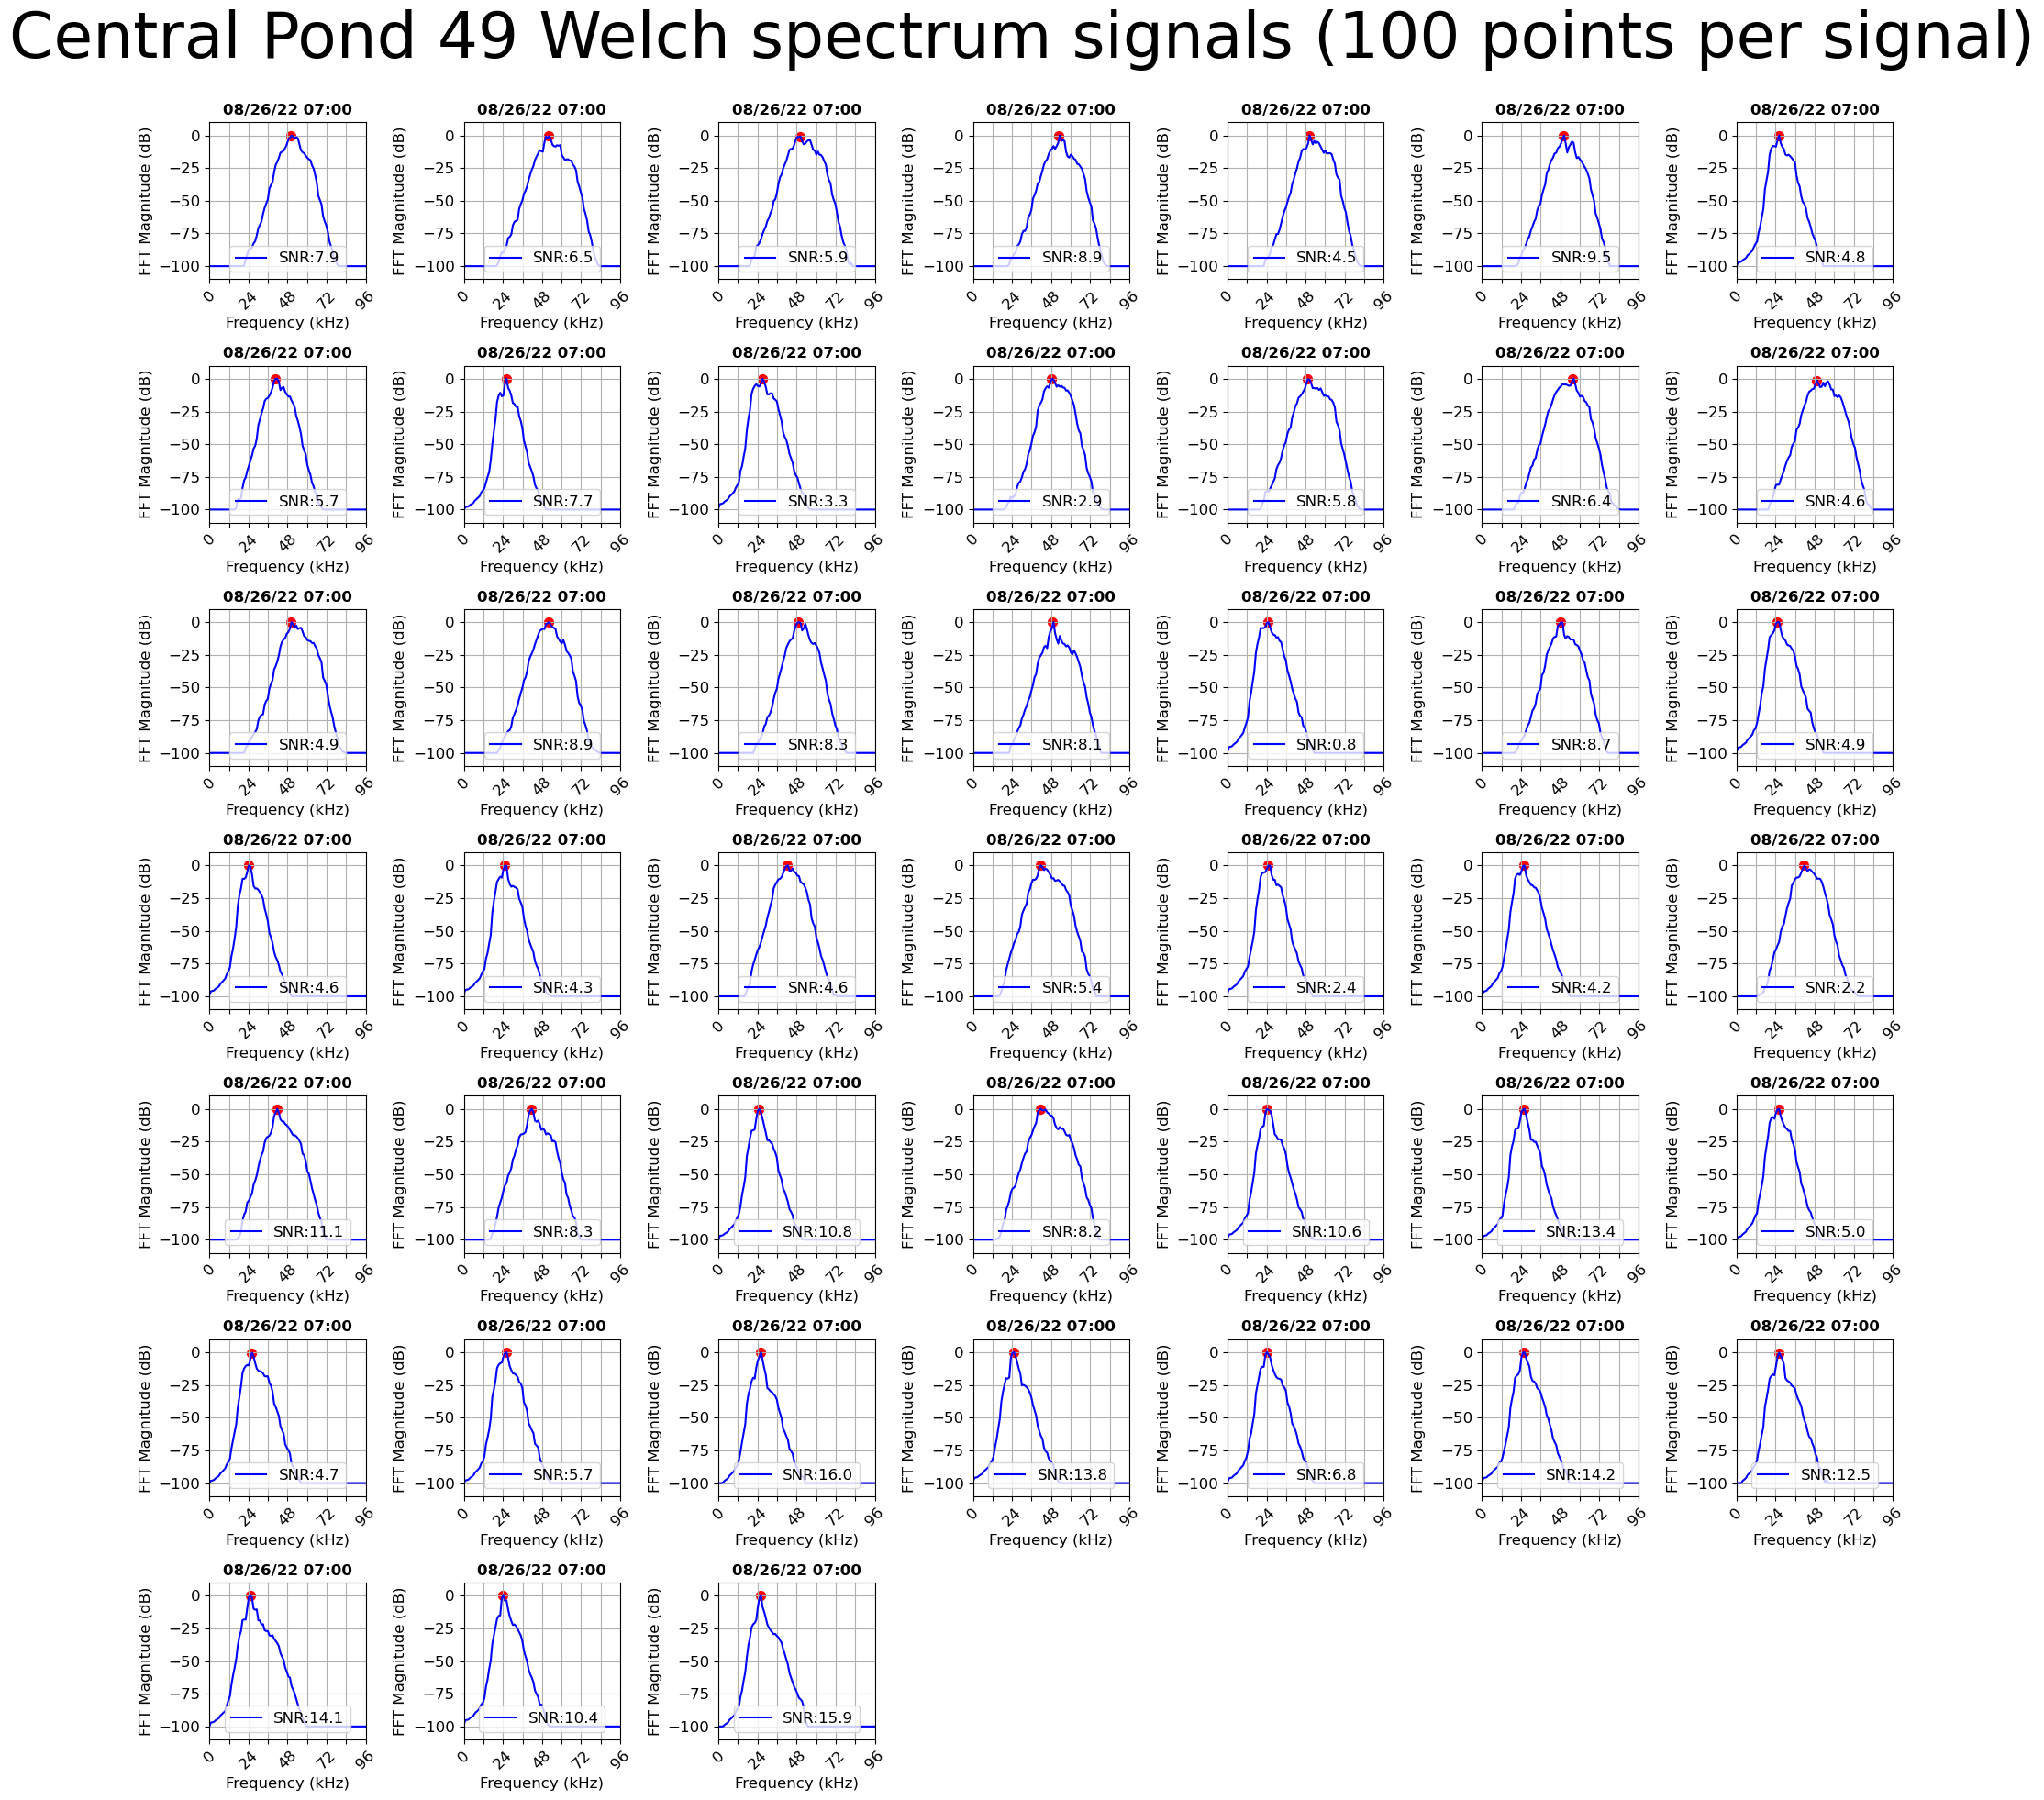

In [15]:
call_indices = np.arange(0, len(dets)).astype('int')
plot_n_welch_square_layout(call_indices, dets, call_signals, site_key)

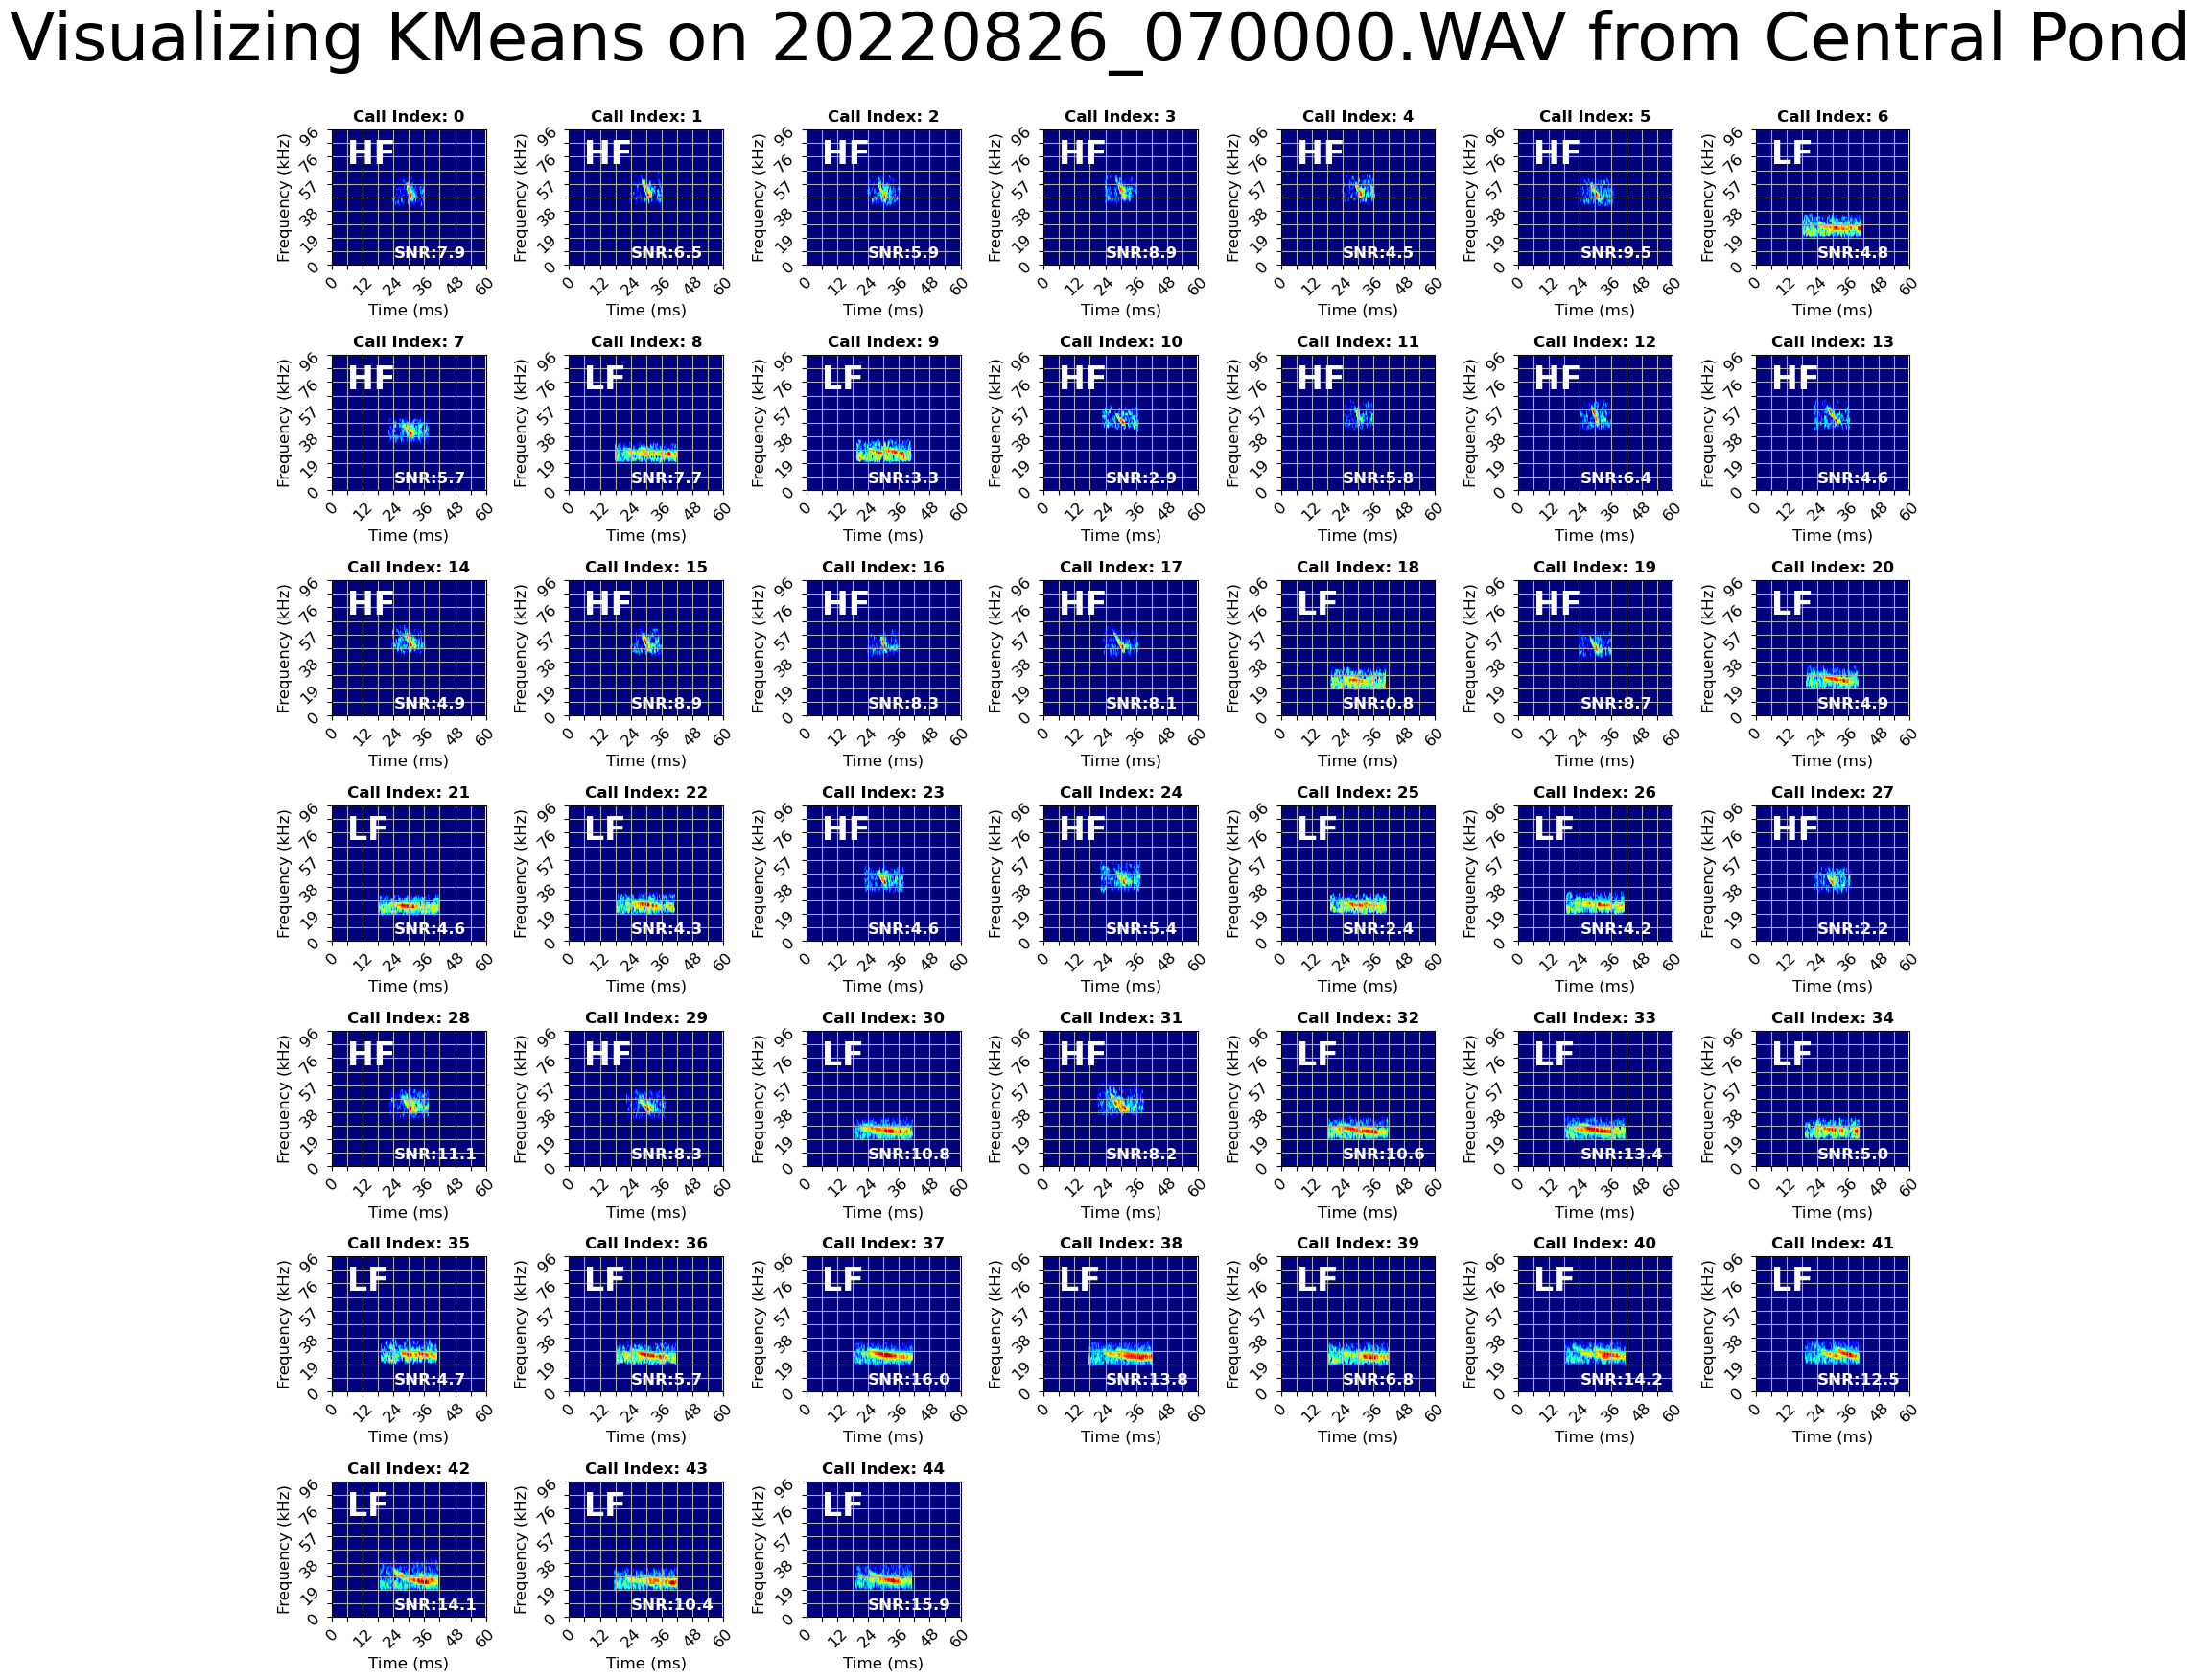

In [16]:
plot_n_specs_square_layout(call_indices, dets, call_signals, site_key)

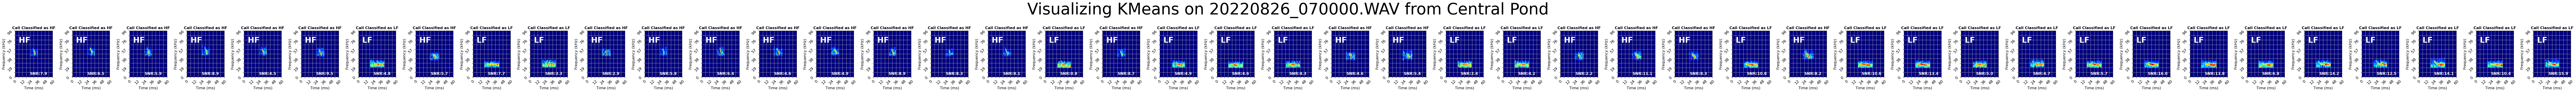

In [17]:
plot_n_specs_long_layout(call_indices, dets, call_signals, site_key)